# Working with Bag of Words

Dataset: spam-ham phone text dataset: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [20]:
# start the graph session
sess = tf.Session()

### Downloading/ reading data

In [21]:
# if the data file is saved, then do not download it again
save_file_name = os.path.join('temp', 'temp_spam_data.csv')

if not os.path.exists('temp'):
    os.makedirs('temp')
    
if os.path.isfile(save_file_name):
    # if the file exists, just read its
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
            
else:
    # if it does not, download it
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x) > 1]
    
    # write to csv
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)
        
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]

### Normalizing data

In [22]:
# Spam is 1, ham is 0
target = [1 if x=='spam' else 0 for x in target]

# Lower case
texts = [x.lower() for x in texts]

# Remove punctuation
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# Remove numbers
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# trim extra whitespace
texts = [' '.join(x.split()) for x in texts]

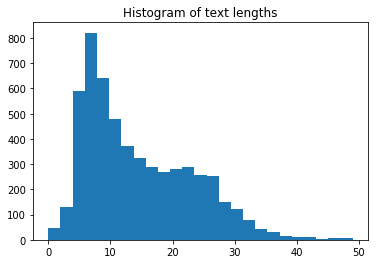

In [23]:
# what are the sentences sizes?
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 50]
plt.hist(text_lengths, bins=25)
plt.title('Histogram of text lengths')
plt.show()

In [24]:
# choosing 25 as max text word, and filter out words that do not appear at least 3 times
sentence_size = 25
min_word_freq = 3

In [25]:
#TensorFlow has a built-in processing tool for determining vocabulary embedding, 
#called VocabularyProcessor(), under the learn.preprocessing library:

vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, min_frequency= min_word_freq)

# transforms the document using the vocabulary
transformed_texts = np.array([x for x in vocab_processor.transform(texts)])

# how many unique words do we have?
embedding_size = len(np.unique(transformed_texts))
embedding_size

8165

### Train and test split

In [26]:
# take 80% of the data indices
train_indices = np.random.choice(len(texts), round(len(texts)*0.8), replace = False)
# and all the rest of the indices
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))

texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]

target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

### Creation of the model

In [27]:
# Since the indices will be translated into a one-hot encoded vector, 
# an identity matrix of [embedding_size] will be created. Iw will be used to look up the 
# sparse vector for each word and add them together for a sparse sentence word.

identity_mat = tf.diag(tf.ones(shape= [embedding_size]))

# The model will use logistic regression. 
A = tf.Variable(tf.random_normal(shape=[embedding_size, 1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# placeholders. The X_data has type int because it will look up the row index of the
# identity matrix

x_data = tf.placeholder(shape=[sentence_size], dtype=tf.int32)
y_target = tf.placeholder(shape=[1,1], dtype= tf.float32)

Next,  the text-word embedding lookup with the prior identity matrix. It will map the indices of the 
words in the sentence to the one-hot-encoded vectors of our identity matrix.

The logistic regression will use the counts of the words as the input. The counts are created by summing the embedding output across the rows.

In [28]:
# Text- vocab embedding
# x_embed will have dimansions (1, embedding_size)
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
# sum across rows
x_col_sums = tf.reduce_sum(x_embed,0)

# Declare model operations
# expand the input dimensions, so that linear regression can be performed on it
x_col_sums_2D = tf.expand_dims(x_col_sums, 0)
model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)

### Loss and optimizer

In [29]:
# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= model_output, labels= y_target))

# Prediction
prediction = tf.sigmoid(model_output)

# optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

### Training

In [30]:
print('Starting Training Over {} Sentences.'.format(len(texts_train)))
loss_vec = []
train_acc_all = []
train_acc_avg = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [[target_train[ix]]]
    
    sess.run(train_step, feed_dict={x_data: t, y_target: y_data})
    temp_loss = sess.run(loss, feed_dict={x_data: t, y_target: y_data})
    loss_vec.append(temp_loss)
    
    if (ix+1)%10==0:
        print('Training Observation #' + str(ix+1) + ': Loss = ' + str(temp_loss))
        
        # Keep trailing average of past 50 observations accuracy
        # Get prediction of single observation
        temp_pred = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
        # Get True/False if prediction is accurate
        train_acc_temp = target_train[ix]==np.round(temp_pred)
        train_acc_all.append(train_acc_temp)
        if len(train_acc_all) >= 50:
            train_acc_avg.append(np.mean(train_acc_all[-50:]))

Starting Training Over 4459 Sentences.
Training Observation #10: Loss = 6.076842
Training Observation #20: Loss = 0.005313548
Training Observation #30: Loss = 0.0031701033
Training Observation #40: Loss = 1.2173673e-05
Training Observation #50: Loss = 0.007795104
Training Observation #60: Loss = 9.60471e-07
Training Observation #70: Loss = 0.009681831
Training Observation #80: Loss = 7.8934494e-07
Training Observation #90: Loss = 0.036967747
Training Observation #100: Loss = 1.2152709
Training Observation #110: Loss = 7.000991e-06
Training Observation #120: Loss = 0.0007126354
Training Observation #130: Loss = 0.00063767604
Training Observation #140: Loss = 13.880115
Training Observation #150: Loss = 3.5934556
Training Observation #160: Loss = 1.1005588
Training Observation #170: Loss = 0.00014791511
Training Observation #180: Loss = 0.00013202426
Training Observation #190: Loss = 0.027400695
Training Observation #200: Loss = 1.9420666e-05
Training Observation #210: Loss = 0.43925306
T

Training Observation #1780: Loss = 4.3576998e-05
Training Observation #1790: Loss = 0.0024586115
Training Observation #1800: Loss = 0.00068637583
Training Observation #1810: Loss = 2.4238567
Training Observation #1820: Loss = 0.0035375203
Training Observation #1830: Loss = 6.7751927
Training Observation #1840: Loss = 0.0068407096
Training Observation #1850: Loss = 4.7718225
Training Observation #1860: Loss = 0.0007661102
Training Observation #1870: Loss = 0.4855163
Training Observation #1880: Loss = 0.0018864516
Training Observation #1890: Loss = 5.636088
Training Observation #1900: Loss = 0.0002275395
Training Observation #1910: Loss = 5.9910573e-05
Training Observation #1920: Loss = 0.0005816425
Training Observation #1930: Loss = 4.9207905e-05
Training Observation #1940: Loss = 0.0033736168
Training Observation #1950: Loss = 4.221162
Training Observation #1960: Loss = 6.2364765e-05
Training Observation #1970: Loss = 0.005042029
Training Observation #1980: Loss = 0.0005926026
Training

Training Observation #3520: Loss = 0.43395346
Training Observation #3530: Loss = 4.61607
Training Observation #3540: Loss = 5.8030997e-05
Training Observation #3550: Loss = 0.0002697744
Training Observation #3560: Loss = 0.004239654
Training Observation #3570: Loss = 0.00014887184
Training Observation #3580: Loss = 4.2762207e-05
Training Observation #3590: Loss = 0.27428082
Training Observation #3600: Loss = 0.85009575
Training Observation #3610: Loss = 0.00038727472
Training Observation #3620: Loss = 4.348058
Training Observation #3630: Loss = 0.010096455
Training Observation #3640: Loss = 1.4348035
Training Observation #3650: Loss = 0.045249417
Training Observation #3660: Loss = 0.0691248
Training Observation #3670: Loss = 0.4990054
Training Observation #3680: Loss = 0.087334804
Training Observation #3690: Loss = 0.64136404
Training Observation #3700: Loss = 0.010032798
Training Observation #3710: Loss = 3.7458474e-05
Training Observation #3720: Loss = 0.77698725
Training Observation

### Testing

In [14]:
# Get test set accuracy
print('Getting Test Set Accuracy For {} Sentences.'.format(len(texts_test)))
test_acc_all = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_test)):
    y_data = [[target_test[ix]]]
    
    if (ix+1)%50==0:
        print('Test Observation #' + str(ix+1))    
    
    # Keep trailing average of past 50 observations accuracy
    # Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    # Get True/False if prediction is accurate
    test_acc_temp = target_test[ix]==np.round(temp_pred)
    test_acc_all.append(test_acc_temp)

print('\nOverall Test Accuracy: {}'.format(np.mean(test_acc_all)))

Getting Test Set Accuracy For 1115 Sentences.
Test Observation #50
Test Observation #100
Test Observation #150
Test Observation #200
Test Observation #250
Test Observation #300
Test Observation #350
Test Observation #400
Test Observation #450
Test Observation #500
Test Observation #550
Test Observation #600
Test Observation #650
Test Observation #700
Test Observation #750
Test Observation #800
Test Observation #850
Test Observation #900
Test Observation #950
Test Observation #1000
Test Observation #1050
Test Observation #1100

Overall Test Accuracy: 0.7838565022421524


### Plotting Accuracy

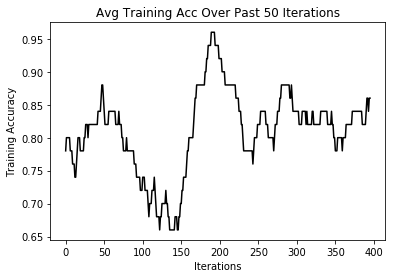

In [31]:
# Plot training accuracy over time
plt.plot(range(len(train_acc_avg)), train_acc_avg, 'k-', label='Train Accuracy')
plt.title('Avg Training Acc Over Past 50 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Training Accuracy')
plt.show()

It is worthwhile to mention the motivation of limiting the sentence (or text) size. This is a common practice with bag of words because it limits the effect of text length on the prediction. <br>

If there is a word, “meeting” for example, that is predictive of a text being ham (not spam), then a spam message might get through by putting in many occurrences of that word at the end. In fact, this is a common problem with imbalanced target data. Imbalanced data might occur in this situation, since spam may be hard to find and ham may be easy to find.


Because of this fact, our vocabulary that we create might be heavily skewed toward words represented in the ham part of our data (more ham means more words are represented in ham than spam). If unlimited length of texts is allowed, then spammers might take advantage of this and create very long texts, which have a higher probability of triggering non-spam word factors in the logistic model.